# Machine Learning - Model Generator

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model for each state
- select state models with selected r2 threshold to save and include in webpage
- save the data for the selected states to use on the web interface

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:
$   pip install psycopg2
$   pip install psycopg2-binary 

In [1]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
#import joblib as jb
import pickle

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [4]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [5]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# List tables in database
inspect(engine).get_table_names()

['economic_features_full',
 'features_table',
 'target_table',
 'economic_features',
 'high_low_poverty']

In [8]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [9]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [10]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [11]:
# Calculate additional features
econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']

In [12]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million', 'population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.loc[model_df.state=="National"].dropna().tail()

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
45,2015,National,384.6,5.366365,3.10,5.37,7.883922,237.017,0.1,48098.63,14.33,3190.966799,1420.842492
46,2016,National,397.5,4.933476,3.01,4.93,8.084510,240.007,1.3,48642.15,13.94,3251.176208,1416.674611
47,2017,National,394.9,4.404787,2.90,4.40,8.320392,245.120,2.1,50321.89,13.91,3450.065821,1383.400078
48,2018,National,383.4,3.937875,2.90,3.94,8.559412,251.107,2.4,52145.80,12.73,3397.485604,1353.353649
49,2019,National,379.4,3.718367,2.70,3.72,9.068824,255.657,1.8,54099.99,12.30,3602.815765,1413.607955


## Model for 1 state

In [13]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Nebraska',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Wisconsin', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wyoming'], dtype=object)

X shape: (36, 10)
---- SHAPES ---
(36,)
(36, 10)
----- EVALUATION ------
Mean absolute error: 0.2711447652756457
Mean square error: 0.10582871508926822
r2 score: 0.9849244690462529
Coefficients: [-3.70963862e-03  6.30617641e-01 -1.60643963e+00 -2.51751117e-01
 -1.10746566e+00 -2.54545335e-02  1.06160546e-01  1.40761691e-04
 -2.56554033e-03 -4.03863311e-04]
Intercept: 49.38149942456137


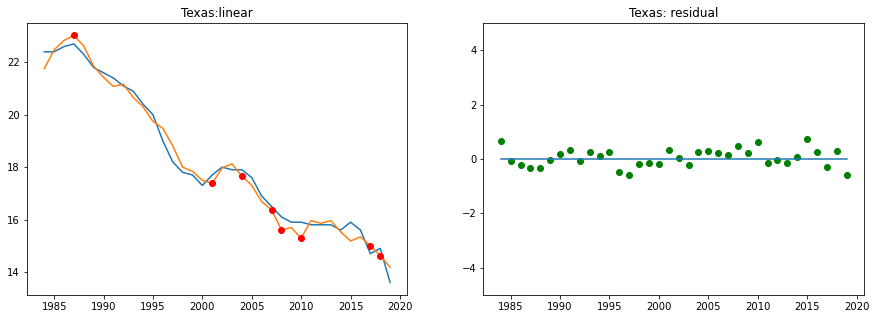

In [14]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

# Create a model with scikit-learn
model = LinearRegression()

# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

# Fit the data into the model
# By convention, X is capitalized and y is lowercase
#model.fit(X, y)

# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)

## Use this to plot training data
y_pred_test = model.predict(X_test)

print('---- SHAPES ---')
print(y_pred.shape)
print(X.shape)
print('----- EVALUATION ------')
print(f'Mean absolute error: {mean_absolute_error(y,y_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_pred)}')
print(f'r2 score: {r2_score(y,y_pred)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
ax[0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
ax[0].set_title(f'{state_to_model}:linear')

ax[1].plot(model_state_df.index.values, (model_state_df['poverty_rate']-model_state_df['predicted_poverty']),
          color='g', marker='o', lw=0)
ax[1].set_title(f'{state_to_model}: residual')
ax[1].set_ylim([-5,5])
ax[1].plot([model_state_df.index.values.min(),model_state_df.index.values.max()],[0,0])
plt.show()

In [15]:
X.columns

Index(['crime_rate', 'unemployment_rate', 'divorce_rate_per_1000_people',
       'homeownership_rate', 'minimum_wage_effective', 'cpi_average',
       'inflation_rate', 'avg_wage_index', 'education_per_capita',
       'welfare_per_capita'],
      dtype='object')

## Create Function

In [16]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_model(df, model_type='linear', use_training_test_split=False):

####    Set up split used for training/test size
    training_size = 0.9
##############################################################
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots, 2 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        if model_type=='linear':
            model = LinearRegression()
        elif model_type =='ridge':
            model = Ridge(alpha=0.5)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
        else:
            model = LinearRegression()
    
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        
        if use_training_test_split:
            model.fit(X_train, y_train)
        else:
            model.fit(X,y)
            
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        m_df['predicted_poverty'] = y_pred
    
    # Use y_pred_test to plot testing points
        if use_training_test_split:
            y_pred_test = model.predict(X_test)
            r2s = r2_score(y_test,y_pred_test)
        else:
            r2s = r2_score(y, y_pred)
 
    # Plot state results
        ax[row][0].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty'])
        ax[row][0].set_title(f'{state}: r2 score:{r2s:.3f}')
        ax[row][1].plot(m_df.index.values,(m_df['poverty_rate']-m_df['predicted_poverty']),color='g', marker='o', lw=0)
        ax[row][1].set_title(f'{state}: residual')
        ax[row][1].set_ylim([-5,5])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[0,0])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[1,1], color='r')
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[-1,-1], color='r')
        if use_training_test_split:
            ax[row][0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)

            
        if use_training_test_split:
            result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error': mean_squared_error(y_test,y_pred_test),
                    'r2 score': r2s,
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        else:
            result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y,y_pred),
                    'Mean square error': mean_squared_error(y,y_pred),
                    'r2 score': r2s,
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

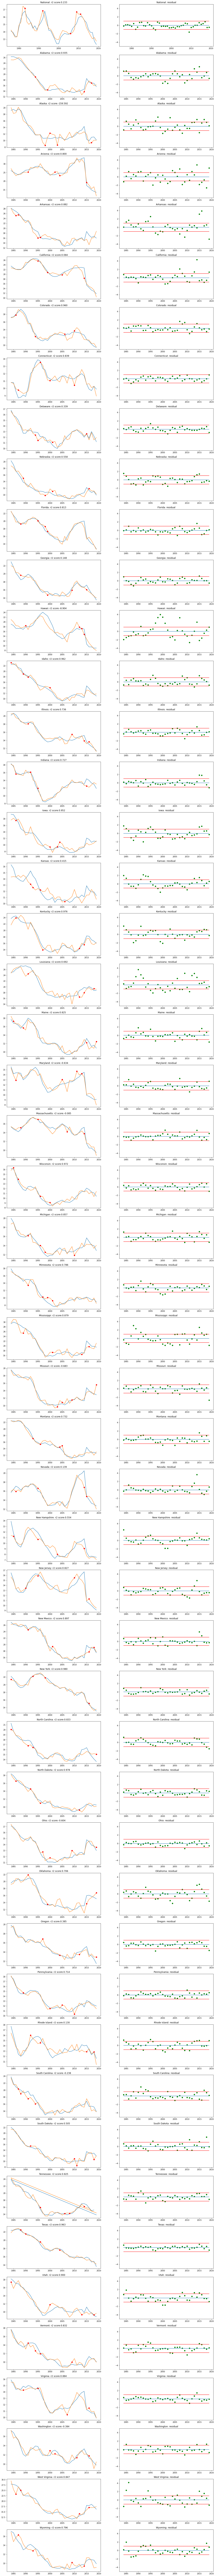

In [17]:
result_df = pd.DataFrame()

result = run_model(model_df, 'linear', True)
result_df = result_df.append(result, ignore_index=True)


## States by their r2 score

In [18]:
result_df.sort_values(by='r2 score', ascending=False).reset_index(drop=True)

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,State,r2 score
0,"[-0.0017835168727250953, 0.02359804543525111, ...",-4.076746,0.332795,0.202812,linear,New York,0.979930
1,"[0.01167319567501587, 0.13714931696051677, -2....",57.062864,0.359212,0.183386,linear,North Dakota,0.978355
2,"[0.0125381252564071, 0.39752583121153384, -2.4...",100.891504,0.564641,0.399019,linear,Kentucky,0.976420
3,"[-0.003211505566836434, 0.3708430366142886, -2...",51.435906,0.458728,0.240190,linear,Wisconsin,0.972038
4,"[-0.00363346944597271, 0.5571337431768383, -0....",43.736390,0.292640,0.121106,linear,Texas,0.963021
5,"[0.014526821335879856, 0.5575340580322575, 4.9...",9.434712,0.575074,0.437084,linear,Idaho,0.961900
6,"[-0.0013185236865596044, 0.9406483388556897, 0...",36.000552,0.413821,0.198474,linear,Colorado,0.960320
7,"[-0.002588849204908152, 0.771883093899594, -3....",85.041259,0.753518,0.727965,linear,Iowa,0.952397
8,"[0.003002339496319408, 1.097316761201856, -6.0...",103.492726,0.295201,0.215169,linear,Alabama,0.935129
9,"[-0.016604161250240706, 0.24482413502905526, -...",65.036836,0.987500,1.306467,linear,Utah,0.900308


## Set r2 threshold and get list of states over the threshold. Check 'National' is always included

In [20]:
r2_threshold = 0.75

In [21]:
states_to_keep = result_df.loc[result_df['r2 score']>=r2_threshold].State.unique()
if ~('National' in states_to_keep):
    states_to_keep = np.append(states_to_keep,'National')
print(f'Number of states to keep: {len(states_to_keep)}')
states_to_keep

Number of states to keep: 27


array(['Alabama', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut',
       'Florida', 'Idaho', 'Iowa', 'Kentucky', 'Maine', 'Wisconsin',
       'Michigan', 'Minnesota', 'Mississippi', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Tennessee', 'Texas',
       'Utah', 'Vermont', 'Virginia', 'West Virginia', 'Wyoming',
       'National'], dtype=object)

## Generate models for selected states and save to specific folder

In [26]:
# Trim the dataset and save to csv file to be used in webpage
trimmed_data_df = model_df.loc[model_df['state'].isin(states_to_keep)].dropna()
trimmed_data_df.to_csv('../Visualizations/webpage/static/state_data.csv', index=False, index_label=False)
trimmed_data_df.to_json('../Visualizations/webpage/static/state_data.json', orient='records')

In [27]:
model_list_df = pd.DataFrame()

filepath = "Best_Models/"

# Create, train and save a model for each state in states_to_keep
# keep a summary dataframe

for state in states_to_keep:
    m_df = trimmed_data_df.loc[trimmed_data_df['state']==state].set_index('year')
    m_df.drop(columns=['state'], inplace=True)
    X = m_df.drop(columns=['poverty_rate'])
    y = m_df['poverty_rate']
    
    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)
    r2s = r2_score(y, y_pred)
    
    model_filename = state + '.sav'
    path_filename = filepath + model_filename
    
    state_info = {'state':state,
                    'model_name':model_filename,
                     'r2_score':r2s}
    
    # save model
    pickle.dump(model, open(path_filename, 'wb'))
    
    model_list_df = model_list_df.append(state_info, ignore_index=True)

model_list_df
model_list_df.to_json('model_list.json', orient='records')